# King County Home Price Predictors - An Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from scipy.stats import pearsonr
from itertools import combinations
import warnings


RPSale = pd.read_csv('../../data/raw/EXTR_RPSale.csv')
ResBldg = pd.read_csv('../../data/raw/EXTR_ResBldg.csv')
Parcel = pd.read_csv('../../data/raw/EXTR_Parcel.csv')

# Filtering the Data

### Filtering to The Last 3 Years

In [2]:
Date = RPSale['DocumentDate'].str.split('/', expand=True)
RPSale['MonthSold'] = Date[0].astype('float64')
RPSale['YrSold'] = Date[2].astype('float64')

#Drop original date column
RPSale.drop(columns=['DocumentDate'], axis=1, inplace=True)

In [3]:
#filtering data from 2018, 2019 and 2020 only
years = [2018, 2019, 2020]  
    
properties = RPSale.loc[RPSale['YrSold'].isin(years)]  
    
properties

,ExciseTaxNbr,Major,Minor,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,MonthSold,YrSold
2,2999169,919715,200,192000,20190712001080,,,,,,...,3,N,N,N,N,1,3,,7.0,2019.0
8,3000673,894444,200,185000,20190722001395,,,,,,...,3,N,N,N,N,1,3,,6.0,2019.0
9,3027422,213043,120,560000,20191226000848,,,,,,...,3,N,N,N,N,1,8,,12.0,2019.0
10,3002257,940652,630,435000,20190730001339,,,,,,...,3,N,N,N,N,1,8,,7.0,2019.0
19,3018109,152504,9008,7600000,20191030001615,,,,,,...,3,N,N,N,N,1,2,,10.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351056,2997920,302300,320,0,20190705000539,,,,,,...,15,N,N,N,N,1,8,,5.0,2019.0
351057,3028691,277110,4239,955000,20200103000685,,,,,,...,3,N,N,N,N,1,8,,12.0,2019.0
351058,2934041,388580,3260,1375000,20180604000929,,,,,,...,3,N,N,N,N,1,8,,5.0,2018.0
351062,2935450,219331,270,850000,20180612000762,,,,,,...,3,N,N,N,N,1,8,,6.0,2018.0


In [4]:
properties['YrSold'].value_counts()

2019.0    61351
2018.0    61170
2020.0    20656
Name: YrSold, dtype: int64

In [5]:
properties = properties.rename(columns=str.lower)

In [6]:
properties.head()

,excisetaxnbr,major,minor,saleprice,recordingnbr,volume,page,platnbr,plattype,platlot,...,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,salewarning,monthsold,yrsold
2,2999169,919715,200,192000,20190712001080,,,,,,...,3,N,N,N,N,1,3,,7.0,2019.0
8,3000673,894444,200,185000,20190722001395,,,,,,...,3,N,N,N,N,1,3,,6.0,2019.0
9,3027422,213043,120,560000,20191226000848,,,,,,...,3,N,N,N,N,1,8,,12.0,2019.0
10,3002257,940652,630,435000,20190730001339,,,,,,...,3,N,N,N,N,1,8,,7.0,2019.0
19,3018109,152504,9008,7600000,20191030001615,,,,,,...,3,N,N,N,N,1,2,,10.0,2019.0


### Padding the 'major' and 'minor' columns and merging them together:

In [7]:
properties['major'] = properties['major'].astype(str)
properties['minor'] = properties['minor'].astype(str)

def major_padded(row):
    if len(row) == 6:
        return row
    elif len(row) == 5:
        return '0'+row
    elif len(row) == 4:
        return '00'+row
    elif len(row) == 3:
        return '000'+row
    elif len(row) == 2:
        return '0000'+row
    elif len(row) == 1:
        return '00000'+row
    else:
        return '000000'

def minor_padded(row):
    if len(row) == 4:
        return row
    elif len(row) == 3: 
        return '0'+row
    elif len(row) == 2:
        return '00'+row
    elif len(row) == 1:
        return '000'+row
    else:
        return '0000'
    
properties['major'] = properties.major.apply(major_padded)
properties['minor'] = properties.minor.apply(minor_padded)
properties['major_minor'] = properties['major']+properties['minor']

In [8]:
#Dropping the old columns
to_drop = ['major','minor']
properties.drop(to_drop, axis=1, inplace=True)

In [9]:
#Moving the 'major_minor' column to the front
col_name = 'major_minor'
last_col = properties.pop(col_name)
properties.insert(1, col_name, last_col)

### Narrowing the property type
According to our LookUp file, the residental values are coded as follows:

**11** - Household, single family units

**12** - Multiple family residence (Residential, 2-4 units)

**14** - Residential condominiums

**18** - All other residential not elsewhere coded

In [10]:
properties = properties[properties['propertytype'].isin([11, 12, 14, 18])]
properties

,excisetaxnbr,major_minor,saleprice,recordingnbr,volume,page,platnbr,plattype,platlot,platblock,...,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,salewarning,monthsold,yrsold
9,3027422,2130430120,560000,20191226000848,,,,,,,...,3,N,N,N,N,1,8,,12.0,2019.0
10,3002257,9406520630,435000,20190730001339,,,,,,,...,3,N,N,N,N,1,8,,7.0,2019.0
22,3015516,7797900030,0,20191016000009,,,,,,,...,3,N,N,N,N,1,8,,10.0,2019.0
24,2963345,7574800320,0,20181126001127,,,,,,,...,15,N,N,N,N,1,3,,11.0,2018.0
27,3033993,9264902060,370000,20200214001331,,,,,,,...,2,N,N,N,N,1,8,,2.0,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351043,3045715,4127000898,619000,20200505001286,,,,,,,...,2,N,N,N,N,1,8,,4.0,2020.0
351047,2949086,3597000405,0,20180824000032,,,,,,,...,15,N,N,N,N,1,8,,7.0,2018.0
351056,2997920,3023000320,0,20190705000539,,,,,,,...,15,N,N,N,N,1,8,,5.0,2019.0
351062,2935450,2193310270,850000,20180612000762,,,,,,,...,3,N,N,N,N,1,8,,6.0,2018.0


### Only using sale prices over 0:

In [11]:
properties = properties[properties['saleprice'] > 0]
properties

,excisetaxnbr,major_minor,saleprice,recordingnbr,volume,page,platnbr,plattype,platlot,platblock,...,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,salewarning,monthsold,yrsold
9,3027422,2130430120,560000,20191226000848,,,,,,,...,3,N,N,N,N,1,8,,12.0,2019.0
10,3002257,9406520630,435000,20190730001339,,,,,,,...,3,N,N,N,N,1,8,,7.0,2019.0
27,3033993,9264902060,370000,20200214001331,,,,,,,...,2,N,N,N,N,1,8,,2.0,2020.0
42,3043271,5703500010,575000,20200417000249,,,,,,,...,2,N,N,N,N,1,8,,4.0,2020.0
50,2937935,8731780100,185000,20180625000560,,,,,,,...,3,N,N,N,N,1,3,,6.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351038,3025068,6150200505,745000,20191212000602,,,,,,,...,3,N,N,N,N,1,8,,11.0,2019.0
351040,2986698,0333100255,6500000,20190508000847,,,,,,,...,3,N,N,N,N,1,8,,4.0,2019.0
351041,3038910,0267700310,455000,20200317001112,,,,,,,...,2,N,N,N,N,1,3,,3.0,2020.0
351043,3045715,4127000898,619000,20200505001286,,,,,,,...,2,N,N,N,N,1,8,,4.0,2020.0


In [12]:
properties['saleprice'].describe()

count    4.776000e+04
mean     7.446527e+05
std      6.547413e+05
min      5.000000e+00
25%      4.250000e+05
50%      6.180000e+05
75%      8.680000e+05
max      5.300000e+07
Name: saleprice, dtype: float64

### Filtering out based on principal use:

In [13]:
properties['principaluse'].unique()

array([6, 2, 7, 0], dtype=int64)

According to our lookup, 

**6** - Residential

**2** - Condominium

**7** - Commercial

I will only focus on residential and condo properties.

In [14]:
properties = properties[properties['principaluse'].isin([6,2])]
properties

,excisetaxnbr,major_minor,saleprice,recordingnbr,volume,page,platnbr,plattype,platlot,platblock,...,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,salewarning,monthsold,yrsold
9,3027422,2130430120,560000,20191226000848,,,,,,,...,3,N,N,N,N,1,8,,12.0,2019.0
10,3002257,9406520630,435000,20190730001339,,,,,,,...,3,N,N,N,N,1,8,,7.0,2019.0
27,3033993,9264902060,370000,20200214001331,,,,,,,...,2,N,N,N,N,1,8,,2.0,2020.0
42,3043271,5703500010,575000,20200417000249,,,,,,,...,2,N,N,N,N,1,8,,4.0,2020.0
50,2937935,8731780100,185000,20180625000560,,,,,,,...,3,N,N,N,N,1,3,,6.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351038,3025068,6150200505,745000,20191212000602,,,,,,,...,3,N,N,N,N,1,8,,11.0,2019.0
351040,2986698,0333100255,6500000,20190508000847,,,,,,,...,3,N,N,N,N,1,8,,4.0,2019.0
351041,3038910,0267700310,455000,20200317001112,,,,,,,...,2,N,N,N,N,1,3,,3.0,2020.0
351043,3045715,4127000898,619000,20200505001286,,,,,,,...,2,N,N,N,N,1,8,,4.0,2020.0


### Checking for 'propertyclass'

In [15]:
properties['propertyclass'].unique()

array([8, 3, 7, 9], dtype=int64)

The follwing values and their definitions are found in our lookup file:

**7** - Res-Land only (I will remove this to only display residential property)

I will keep:

**8** - Residential- Improved Property

**3** - Condominium

**9** - Res/Condo mobile

In [16]:
properties = properties[properties['propertyclass'].isin([8,3,9])]
properties.head()

,excisetaxnbr,major_minor,saleprice,recordingnbr,volume,page,platnbr,plattype,platlot,platblock,...,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,salewarning,monthsold,yrsold
9,3027422,2130430120,560000,20191226000848,,,,,,,...,3,N,N,N,N,1,8,,12.0,2019.0
10,3002257,9406520630,435000,20190730001339,,,,,,,...,3,N,N,N,N,1,8,,7.0,2019.0
27,3033993,9264902060,370000,20200214001331,,,,,,,...,2,N,N,N,N,1,8,,2.0,2020.0
42,3043271,5703500010,575000,20200417000249,,,,,,,...,2,N,N,N,N,1,8,,4.0,2020.0
50,2937935,8731780100,185000,20180625000560,,,,,,,...,3,N,N,N,N,1,3,,6.0,2018.0


### Checking for duplicates based on major_minor numbers

In [17]:
len(properties) - len(properties.major_minor.unique())

1585

I will check to see if there are any trends in the duplicates, since it is possible a home could have been sold more than once during the set timeframe.

In [18]:
properties[properties['major_minor'].isin(['8843900445','8847500000'])]

,excisetaxnbr,major_minor,saleprice,recordingnbr,volume,page,platnbr,plattype,platlot,platblock,...,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,salewarning,monthsold,yrsold
41899,2975737,8843900445,815000,20190228001472,,,,,,,...,3,N,N,N,N,1,8,,2.0,2019.0
149957,2975141,8843900445,699900,20190226001189,,,,,,,...,3,N,N,N,N,1,8,,2.0,2019.0
162622,2993692,8847500000,764990,20190614000861,,,,,,,...,3,N,N,N,N,1,3,,6.0,2019.0
197942,2976965,8843900445,706900,20190311000874,,,,,,,...,3,N,N,N,N,1,8,,3.0,2019.0
210949,3020478,8847500000,698654,20191114000503,,,,,,,...,3,N,N,N,N,1,3,,11.0,2019.0
292126,2980974,8843900445,799900,20190405000497,,,,,,,...,3,N,N,N,N,1,8,,3.0,2019.0
294166,2975973,8843900445,782900,20190301000951,,,,,,,...,3,N,N,N,N,1,8,,2.0,2019.0
312455,2975726,8843900445,776900,20190228001436,,,,,,,...,3,N,N,N,N,1,8,,2.0,2019.0
332992,2976878,8847500000,784684,20190311000330,,,,,,,...,3,N,N,N,N,1,3,43,3.0,2019.0


In [19]:
#Dropping the duplicates
properties.drop_duplicates(subset='major_minor', keep='last', inplace=True)

<ipython-input-19-6281fb0af3f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties.drop_duplicates(subset='major_minor', keep='last', inplace=True)


In [20]:
properties.head()

,excisetaxnbr,major_minor,saleprice,recordingnbr,volume,page,platnbr,plattype,platlot,platblock,...,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,salewarning,monthsold,yrsold
9,3027422,2130430120,560000,20191226000848,,,,,,,...,3,N,N,N,N,1,8,,12.0,2019.0
10,3002257,9406520630,435000,20190730001339,,,,,,,...,3,N,N,N,N,1,8,,7.0,2019.0
27,3033993,9264902060,370000,20200214001331,,,,,,,...,2,N,N,N,N,1,8,,2.0,2020.0
50,2937935,8731780100,185000,20180625000560,,,,,,,...,3,N,N,N,N,1,3,,6.0,2018.0
55,2926991,2211700075,1425000,20180427001349,,,,,,,...,3,N,N,N,N,1,8,,4.0,2018.0


In [21]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45203 entries, 9 to 351062
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   excisetaxnbr        45203 non-null  int64  
 1   major_minor         45203 non-null  object 
 2   saleprice           45203 non-null  int64  
 3   recordingnbr        45203 non-null  object 
 4   volume              45203 non-null  object 
 5   page                45203 non-null  object 
 6   platnbr             45203 non-null  object 
 7   plattype            45203 non-null  object 
 8   platlot             45203 non-null  object 
 9   platblock           45203 non-null  object 
 10  sellername          45203 non-null  object 
 11  buyername           45203 non-null  object 
 12  propertytype        45203 non-null  int64  
 13  principaluse        45203 non-null  int64  
 14  saleinstrument      45203 non-null  int64  
 15  afforestland        45203 non-null  object 
 16  afc

In [22]:
to_drop = ['volume', 'page', 'platnbr', 'plattype', 'platlot', 'platblock', 'sellername', 'buyername']
properties.drop(to_drop, axis=1, inplace=True)

C:\Users\15164\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [23]:
properties.head()

,excisetaxnbr,major_minor,saleprice,recordingnbr,propertytype,principaluse,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,salewarning,monthsold,yrsold
9,3027422,2130430120,560000,20191226000848,11,6,3,N,N,N,N,1,8,,12.0,2019.0
10,3002257,9406520630,435000,20190730001339,11,6,3,N,N,N,N,1,8,,7.0,2019.0
27,3033993,9264902060,370000,20200214001331,11,6,2,N,N,N,N,1,8,,2.0,2020.0
50,2937935,8731780100,185000,20180625000560,14,2,3,N,N,N,N,1,3,,6.0,2018.0
55,2926991,2211700075,1425000,20180427001349,11,6,3,N,N,N,N,1,8,,4.0,2018.0


Now I'll repeat everything I did for "properties" and apply it to residential buildings.

In [24]:
ResBldg.rename(columns=str.lower, inplace=True)
ResBldg['major'] = ResBldg['major'].astype(str)
ResBldg['minor'] = ResBldg['minor'].astype(str)

ResBldg['major'] = ResBldg['major'].apply(major_padded)
ResBldg['minor'] = ResBldg['minor'].apply(minor_padded)

ResBldg['major_minor'] = ResBldg['major']+ResBldg['minor']

col_name = 'major_minor'
last_col = ResBldg.pop(col_name)
ResBldg.insert(0, col_name, last_col)

ResBldg.head(2)

,major_minor,major,minor,bldgnbr,nbrlivingunits,address,buildingnumber,fraction,directionprefix,streetname,...,fpmultistory,fpfreestanding,fpadditional,yrbuilt,yrrenovated,pcntcomplete,obsolescence,pcntnetcondition,condition,addnlcost
0,0098000720,009800,0720,1,1,27719 SE 26TH WAY 98075,27719,,SE,26TH,...,0,0,0,2001,0,0,0,0,3,0
1,0098020140,009802,0140,1,1,2829 277TH TER SE 98075,2829,,,277TH,...,0,0,0,2004,0,0,0,0,3,0


In [25]:
sum(ResBldg.minor == '0000')

0

Since residential buildings don't have condominiums (**Minor=0000**), I will be forced to drop more data.

In [26]:
ResBldg.loc[1]

major_minor                           0098020140
major                                     009802
minor                                       0140
bldgnbr                                        1
nbrlivingunits                                 1
address               2829   277TH TER SE  98075
buildingnumber                             2829 
fraction                                        
directionprefix                                 
streetname             277TH                    
streettype                                TER   
directionsuffix                               SE
zipcode                                    98075
stories                                        2
bldggrade                                     10
bldggradevar                                   0
sqft1stfloor                                1610
sqfthalffloor                                  0
sqft2ndfloor                                1400
sqftupperfloor                                 0
sqftunfinfull       

In [27]:
ResBldg = ResBldg.dropna(how='any',axis=0)
ResBldg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154594 entries, 0 to 181506
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   major_minor         154594 non-null  object 
 1   major               154594 non-null  object 
 2   minor               154594 non-null  object 
 3   bldgnbr             154594 non-null  int64  
 4   nbrlivingunits      154594 non-null  int64  
 5   address             154594 non-null  object 
 6   buildingnumber      154594 non-null  object 
 7   fraction            154594 non-null  object 
 8   directionprefix     154594 non-null  object 
 9   streetname          154594 non-null  object 
 10  streettype          154594 non-null  object 
 11  directionsuffix     154594 non-null  object 
 12  zipcode             154594 non-null  object 
 13  stories             154594 non-null  float64
 14  bldggrade           154594 non-null  int64  
 15  bldggradevar        154594 non-nul

### Converting 'zipcode' to int

In [28]:
ResBldg['zipcode'] = ResBldg['zipcode'].str.split('-').str[0]
ResBldg['zipcode'].value_counts()

98042    4661
98023    4177
98115    4175
98038    3828
98058    3733
         ... 
98097       1
98204       1
95059       1
9059        1
9800        1
Name: zipcode, Length: 122, dtype: int64

In [29]:
ResBldg['zipcode'] = ResBldg['zipcode'].astype(str).str.replace(',', '')
ResBldg['zipcode'] = ResBldg['zipcode'].astype(str).str.replace(' ', '')
ResBldg['zipcode'] = ResBldg['zipcode'].astype(str).str.replace('.', '')

In [30]:
df = ResBldg[ResBldg['zipcode'].apply(lambda x: not x.isnumeric())]
df

,major_minor,major,minor,bldgnbr,nbrlivingunits,address,buildingnumber,fraction,directionprefix,streetname,...,fpmultistory,fpfreestanding,fpadditional,yrbuilt,yrrenovated,pcntcomplete,obsolescence,pcntnetcondition,condition,addnlcost
71823,3126069112,312606,9112,1,1,11026 AVONDALE RD NE,11026,,,AVONDALE,...,0,0,0,2015,0,0,0,0,3,8000
173514,9828702305,982870,2305,1,1,111 D 26TH AVE E A on plans,111,D,,26TH,...,0,0,0,2019,0,60,0,0,3,0


In [31]:
#Dropping non-numeric zipcode entries
ResBldg = ResBldg.drop(index=[71823,173514])

In [32]:
ResBldg['zipcode'].value_counts()

98042    4661
98023    4177
98115    4175
98038    3828
98058    3756
         ... 
98097       1
98204       1
95059       1
9059        1
9800        1
Name: zipcode, Length: 119, dtype: int64

In [33]:
ResBldg['zipcode']= ResBldg['zipcode'].astype(np.int64)

In [34]:
prop_res = properties.merge(ResBldg, on='major_minor', suffixes=("", " "))
prop_res.describe()

,excisetaxnbr,saleprice,propertytype,principaluse,saleinstrument,salereason,propertyclass,monthsold,yrsold,bldgnbr,...,fpmultistory,fpfreestanding,fpadditional,yrbuilt,yrrenovated,pcntcomplete,obsolescence,pcntnetcondition,condition,addnlcost
count,3.392800e+04,3.392800e+04,33928.000000,33928.0,33928.000000,33928.000000,33928.0,33928.000000,33928.000000,33928.000000,...,33928.000000,33928.000000,33928.000000,33928.000000,33928.000000,33928.000000,33928.000000,33928.000000,33928.000000,33928.000000
mean,2.987995e+06,7.676240e+05,11.024228,6.0,3.073450,1.014914,8.0,6.396781,2018.826839,1.008872,...,0.337921,0.078961,0.198744,1968.021752,110.160133,0.173898,0.110410,0.006425,3.536401,597.927995
std,3.762621e+04,5.874356e+05,0.280116,0.0,2.185849,0.501786,0.0,3.174764,0.708859,0.113924,...,0.512201,0.280399,0.418317,28.385749,456.266456,3.498123,2.103985,0.457740,0.718633,2286.108745
min,2.909403e+06,5.000000e+00,11.000000,6.0,2.000000,1.000000,8.0,1.000000,2018.000000,1.000000,...,0.000000,0.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.956618e+06,4.500000e+05,11.000000,6.0,3.000000,1.000000,8.0,4.000000,2018.000000,1.000000,...,0.000000,0.000000,0.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,2.992006e+06,6.450000e+05,11.000000,6.0,3.000000,1.000000,8.0,6.000000,2019.000000,1.000000,...,0.000000,0.000000,0.000000,1969.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,3.019295e+06,8.850000e+05,11.000000,6.0,3.000000,1.000000,8.0,9.000000,2019.000000,1.000000,...,1.000000,0.000000,0.000000,1990.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
max,3.050093e+06,2.675000e+07,18.000000,6.0,27.000000,18.000000,8.0,12.000000,2020.000000,7.000000,...,5.000000,3.000000,3.000000,2020.000000,2020.000000,100.000000,99.000000,43.000000,5.000000,50000.000000


### Converting the 'yrrenovated' column to a binary
Next, the 'yrrenovated' column has a large amount zero values (denoting that a house hasn't been renovated). Rather than dropping the data, I will make this a binary column whether a house was sold within 10 years of a renovation or not, or built within the last five years. 

First, I will make a new column 'age' with the properties' ages as variables to get a better sense of how old a home is.

In [35]:
#Convert YrBuilt to age by subtracting the build year from the most recent year in the in dataframe
prop_res['age'] = 2020 - prop_res.yrbuilt

Now I will convert the 'yrrenovated' column to a binary column.

In [36]:
prop_res['yrrenovated'].value_counts()

0       32059
2018      173
2019      122
2017       66
2003       58
        ...  
1935        1
1949        1
1944        1
1952        1
1936        1
Name: yrrenovated, Length: 80, dtype: int64

In [37]:
prop_res['yrrenovated'].fillna(0.0, inplace=True)

In [38]:
prop_res['renovated'] = prop_res['yrsold'] - prop_res['yrrenovated']

In [39]:
#Replacing values less than 10 with 1, and values over 10 with 0
Renovated = prop_res.renovated.values
Age = prop_res.age.values
values = np.where(Renovated <= 10, 1, 0)
prop_res['renovated'] = np.where(Age <= 5, 1, values)

Now I'll check again for duplicates:

In [40]:
prop_res.major_minor.value_counts()

6373000170    5
0809003030    5
0952007105    4
2822059059    4
6196600360    4
             ..
1370804435    1
2141330750    1
5309101460    1
1622069090    1
2589300210    1
Name: major_minor, Length: 33671, dtype: int64

In [41]:
prop_res[prop_res['major_minor'].isin(['0809003030', '6373000170', '2822059059'])]

,excisetaxnbr,major_minor,saleprice,recordingnbr,propertytype,principaluse,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,...,fpadditional,yrbuilt,yrrenovated,pcntcomplete,obsolescence,pcntnetcondition,condition,addnlcost,age,renovated
1886,3048606,0809003030,1176000,20200527001133,11,6,3,N,N,N,...,0,2019,0,40,0,0,3,0,1,1
1887,3048606,0809003030,1176000,20200527001133,11,6,3,N,N,N,...,0,2019,0,40,0,0,3,0,1,1
1888,3048606,0809003030,1176000,20200527001133,11,6,3,N,N,N,...,0,2019,0,40,0,0,3,0,1,1
1889,3048606,0809003030,1176000,20200527001133,11,6,3,N,N,N,...,0,2019,0,40,0,0,3,0,1,1
1890,3048606,0809003030,1176000,20200527001133,11,6,3,N,N,N,...,0,2019,0,40,0,0,3,0,1,1
24272,2921369,6373000170,1500000,20180328000779,11,6,3,N,N,N,...,0,2019,0,60,0,0,3,0,1,1
24273,2921369,6373000170,1500000,20180328000779,11,6,3,N,N,N,...,0,2019,0,60,0,0,3,0,1,1
24274,2921369,6373000170,1500000,20180328000779,11,6,3,N,N,N,...,0,2019,0,60,0,0,3,0,1,1
24275,2921369,6373000170,1500000,20180328000779,11,6,3,N,N,N,...,0,2019,0,60,0,0,3,0,1,1
24276,2921369,6373000170,1500000,20180328000779,11,6,3,N,N,N,...,0,2019,0,60,0,0,3,0,1,1


In [42]:
prop_res.drop_duplicates(subset='major_minor', inplace=True)
len(prop_res)

33671

We are now left with 33,671 entries in our data frame.

### Now for our last file, 'Parcel':

In [43]:
Parcel.rename(columns=str.lower, inplace=True)
Parcel['major'] = Parcel['major'].astype(str)
Parcel['minor'] = Parcel['minor'].astype(str)
Parcel['major'] = Parcel['major'].apply(major_padded)
Parcel['minor'] = Parcel['minor'].apply(minor_padded)
Parcel['major_minor'] = Parcel['major']+Parcel['minor']
last_col = Parcel.pop(col_name)
Parcel.insert(0, col_name, last_col)

In [44]:
prop_res = prop_res.merge(Parcel, on='major_minor', suffixes=("", " "))

In [45]:
prop_res.shape

(33671, 150)

In [46]:
prop_res['proptype'].unique()

array(['R'], dtype=object)

Thankfully, we haven't lost any more entries *and* our property type column only contains 'R' (residential) values.

In [47]:
prop_res.describe()

,excisetaxnbr,saleprice,propertytype,principaluse,saleinstrument,salereason,propertyclass,monthsold,yrsold,bldgnbr,...,wfntpoorquality,wfntrestrictedaccess,tidelandshoreland,lotdepthfactor,trafficnoise,airportnoise,nbrbldgsites,contamination,historicsite,currentusedesignation
count,3.367100e+04,3.367100e+04,33671.000000,33671.0,33671.00000,33671.000000,33671.0,33671.000000,33671.000000,33671.000000,...,33671.000000,33671.000000,33671.000000,33671.000000,33671.000000,33671.0,33671.00000,33671.0,33671.000000,33671.000000
mean,2.987987e+06,7.654065e+05,11.023908,6.0,3.07110,1.015028,8.0,6.402958,2018.826141,1.003772,...,0.000713,0.005554,0.015117,0.049004,0.207270,0.0,0.00689,0.0,0.001277,0.002762
std,3.760185e+04,5.794149e+05,0.280319,0.0,2.17568,0.503696,0.0,3.172576,0.708517,0.071995,...,0.026689,0.108990,0.172277,2.031641,0.554123,0.0,0.14849,0.0,0.060917,0.087662
min,2.909403e+06,5.000000e+00,11.000000,6.0,2.00000,1.000000,8.0,1.000000,2018.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
25%,2.956624e+06,4.500000e+05,11.000000,6.0,3.00000,1.000000,8.0,4.000000,2018.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
50%,2.992018e+06,6.450000e+05,11.000000,6.0,3.00000,1.000000,8.0,6.000000,2019.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
75%,3.018590e+06,8.840000e+05,11.000000,6.0,3.00000,1.000000,8.0,9.000000,2019.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
max,3.050093e+06,2.675000e+07,18.000000,6.0,27.00000,18.000000,8.0,12.000000,2020.000000,7.000000,...,1.000000,3.000000,3.000000,109.000000,3.000000,0.0,16.00000,0.0,3.000000,3.000000


**I will select features of a residential property that would have a bearing on its saleprice:**

In [48]:
property_data = prop_res.loc[:, ['saleprice', 'sqfttotliving', 'yrbuilt', 'yrrenovated', 'bedrooms',
                      'zipcode', 'sqfttotbasement', 'sqftfinbasement', 'sqftopenporch',
                      'sqftenclosedporch', 'sqftdeck','heatsystem', 'heatsource', 'bathhalfcount', 
                      'bath3qtrcount', 'bathfullcount','condition', 'viewutilization', 'sqftgarageattached',
                      'daylightbasement','bldggrade', 'finbasementgrade', 'hbuasifvacant', 'inadequateparking', 'township',
                      'mtrainier', 'olympics', 'cascades', 'territorial', 'seattleskyline', 'pugetsound',
                      'lakewashington', 'lakesammamish', 'smalllakerivercreek', 'otherview', 'wfntlocation',
                      'trafficnoise', 'airportnoise', 'powerlines', 'othernuisances', 'adjacentgreenbelt']]

In [49]:
property_data.head()

,saleprice,sqfttotliving,yrbuilt,yrrenovated,bedrooms,zipcode,sqfttotbasement,sqftfinbasement,sqftopenporch,sqftenclosedporch,...,lakewashington,lakesammamish,smalllakerivercreek,otherview,wfntlocation,trafficnoise,airportnoise,powerlines,othernuisances,adjacentgreenbelt
0,560000,1930,1989,0,3,98019,0,0,180,0,...,0,0,0,0,0,0,0,N,N,N
1,435000,1975,1994,0,3,98038,0,0,45,0,...,0,0,0,0,0,0,0,N,N,N
2,370000,1750,1979,0,3,98023,1130,460,0,0,...,0,0,0,0,0,0,0,N,N,N
3,1425000,2850,1985,0,4,98006,0,0,190,0,...,0,0,0,0,0,0,0,N,N,N
4,1085000,1870,2008,0,3,98102,790,790,0,0,...,0,0,0,0,0,0,0,N,N,N


And lastly, I will narrow down the total square foot living space to 4500 (anything more is either a massive mansion or not a single family home, both of which are outside the scope of this analysis) and filter out properties between 10 and 2.5 million.

In [50]:
property_data = property_data[property_data['sqfttotliving'] < 4500]

In [51]:
property_data = property_data[(property_data['saleprice'] < 2500000) & (property_data['saleprice'] > 10)]

In [52]:
property_data.shape

(32732, 41)

In [53]:
cleaned_data = property_data.to_csv('cleaned_data.csv')
property_data = prop_res.to_csv('property_data.csv')

# Investigating the Target Variable: 'saleprice'

In [54]:
kc_data = pd.read_csv('../../data/processed/cleaned_data.csv', index_col=0) #Load w/out the unnecessary 'Unnamed:0' column.
kc_data.head()

,saleprice,sqfttotliving,yrbuilt,yrrenovated,bedrooms,zipcode,sqfttotbasement,sqftfinbasement,sqftopenporch,sqftenclosedporch,...,lakewashington,lakesammamish,smalllakerivercreek,otherview,wfntlocation,trafficnoise,airportnoise,powerlines,othernuisances,adjacentgreenbelt
0,560000,1930,1989,0,3,98019,0,0,180,0,...,0,0,0,0,0,0,0,N,N,N
1,435000,1975,1994,0,3,98038,0,0,45,0,...,0,0,0,0,0,0,0,N,N,N
2,370000,1750,1979,0,3,98023,1130,460,0,0,...,0,0,0,0,0,0,0,N,N,N
3,1425000,2850,1985,0,4,98006,0,0,190,0,...,0,0,0,0,0,0,0,N,N,N
4,1085000,1870,2008,0,3,98102,790,790,0,0,...,0,0,0,0,0,0,0,N,N,N


In [55]:
kc_data.saleprice.describe()

count    3.273200e+04
mean     7.090310e+05
std      3.638994e+05
min      1.000000e+02
25%      4.450000e+05
50%      6.300000e+05
75%      8.600000e+05
max      2.499888e+06
Name: saleprice, dtype: float64

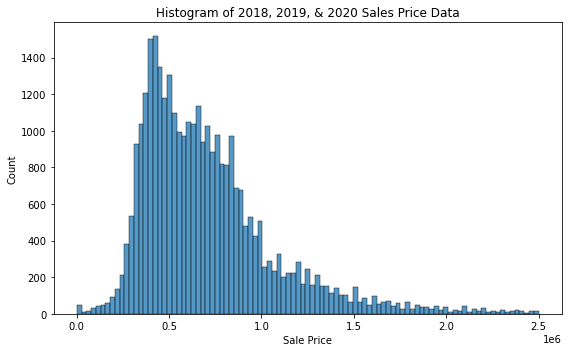

In [56]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Histogram of 2018, 2019, & 2020 Sales Price Data', fontsize = 12)
sns.histplot(kc_data.saleprice, ax = ax)
ax.tick_params(axis='both', labelsize=10)
plt.xlabel('Sale Price', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.tight_layout()

The filtered sales price data is right skewed which is to be expected since houses worth over 2.5 million dollars are included in the data. We see that our mean house price is just over 700K at $709,031.

In [57]:
data_corr = kc_data.corr()

# inspecting correlations with 'saleprice' in descending order to review the highest correlations first
sorted_corrs = data_corr['saleprice'].sort_values(ascending = False)
sorted_corrs

saleprice              1.000000
bldggrade              0.602441
sqfttotliving          0.582776
township               0.469307
bathfullcount          0.285041
territorial            0.271712
bedrooms               0.269357
sqfttotbasement        0.259356
sqftfinbasement        0.250262
finbasementgrade       0.235648
sqftdeck               0.215990
lakewashington         0.208742
sqftopenporch          0.189520
bathhalfcount          0.182185
olympics               0.181842
bath3qtrcount          0.175900
heatsystem             0.164649
pugetsound             0.162597
seattleskyline         0.137477
yrrenovated            0.119026
cascades               0.117952
lakesammamish          0.112703
sqftgarageattached     0.103858
wfntlocation           0.061200
otherview              0.058447
inadequateparking      0.039884
mtrainier              0.027440
smalllakerivercreek    0.026834
hbuasifvacant          0.020691
sqftenclosedporch      0.010737
yrbuilt                0.005304
trafficn

The top 2 highest correlated features with 'saleprice' are 'bldggrade' and 'sqfttotliving'. As is to be expected, houses with larger square footage are more expensive than smaller square foot houses. I will start by investigating this feature and work on building my first model.

## Total Living Square Footage ('sqfttotliving')
I'll start by examining the relationship between total living square footage and sale price.

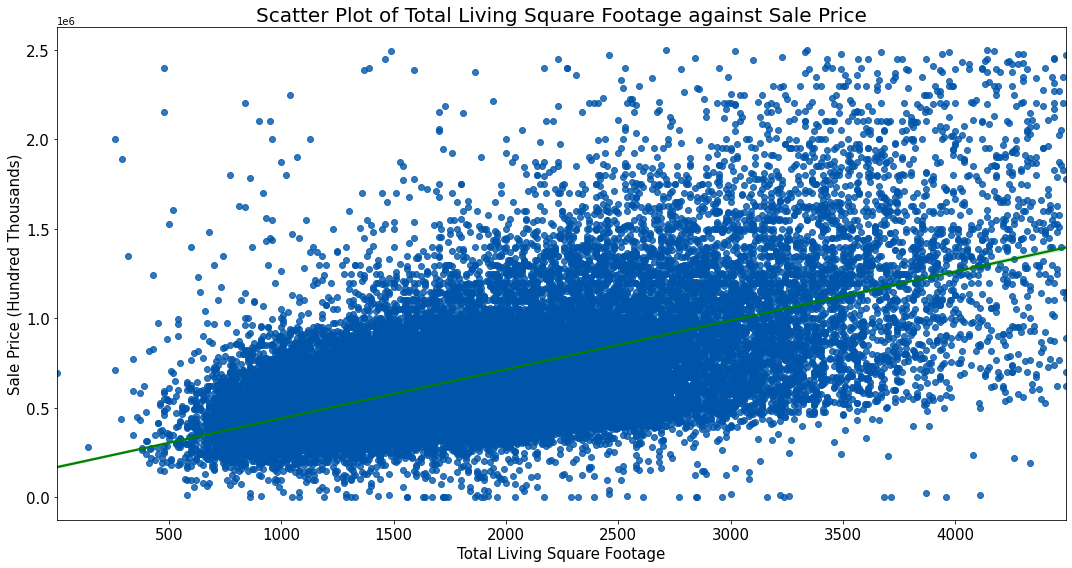

In [58]:
fig, ax = plt.subplots(figsize=(15,8))
sns.regplot(x = 'sqfttotliving', y = 'saleprice', data = kc_data,
            scatter_kws={"color": "#0055AA"}, line_kws={"color": "green"});
ax.set_title('Scatter Plot of Total Living Square Footage against Sale Price', fontsize = 20)
ax.tick_params(axis='both', labelsize=15)
plt.xlabel('Total Living Square Footage', fontsize = 15)
plt.ylabel('Sale Price (Hundred Thousands)', fontsize = 15)
plt.tight_layout()

We can see there is a fairly strong correlation between total living space and sale price.
Let's examine the distribution of sqfttotliving:

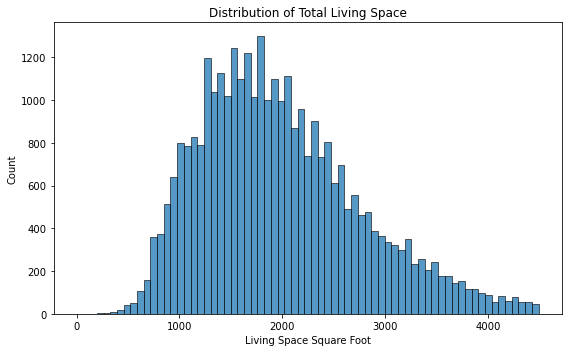

In [59]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title('Distribution of Total Living Space', fontsize = 12)
sns.histplot(kc_data.sqfttotliving, ax = ax)
ax.tick_params(axis = 'both', labelsize = 10)
plt.xlabel('Living Space Square Foot', fontsize = 10)
plt.tight_layout()

I will log-transform the data and examine, since this appears to be slightly right-skewed.

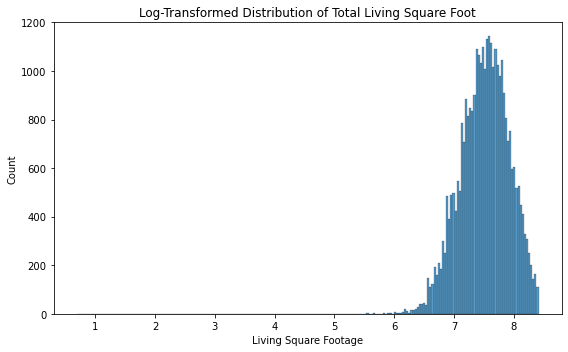

In [60]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title('Log-Transformed Distribution of Total Living Square Foot', fontsize = 12)
sns.histplot(np.log(kc_data.sqfttotliving), ax = ax)
ax.tick_params(axis = 'both', labelsize = 10)
plt.xlabel('Living Square Footage', fontsize = 10)
plt.tight_layout()

The transformation happened to skew it to the left, I will try a square root transformation:

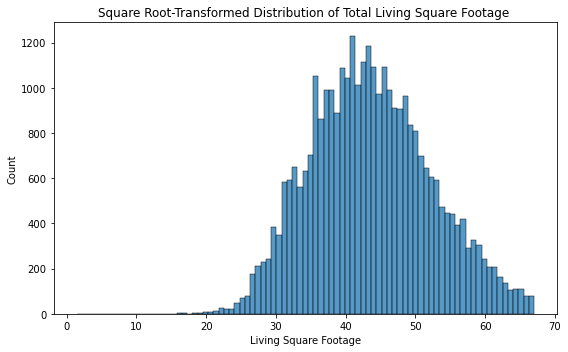

In [61]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title('Square Root-Transformed Distribution of Total Living Square Footage ', fontsize = 12)
sns.histplot(np.sqrt(kc_data.sqfttotliving), ax = ax)
ax.tick_params(axis = 'both', labelsize = 10)
plt.xlabel('Living Square Footage', fontsize = 10)
plt.tight_layout()

There! Now the distribution is fairly normal and should work for modeling.

I'll save this as a column to use later:

In [62]:
kc_data['sqrt_sqfttotliving'] = np.sqrt(kc_data.sqfttotliving)

# First Model: saleprice ~ sqfttotliving

In [63]:
def model(features_lst, df, target_var):
    """
    features_lst is a list of strings of the features to use from the df
    df is the data frame to subset the features from 
    target_var is a string of the target variable
    """

    # Creating a df with only the target and the chosen corellation feature
    df_model = df[features_lst]

    # Building the R-style formula.
    target = target_var
    features_lstcopy = features_lst.copy()
    features_lstcopy.remove(target)
    x_vals = features_lstcopy
    x_formula = '+'.join(x_vals)
    formula = target + '~' + x_formula

    # Fitting the model on the df composed of the two features
    model = ols(formula=formula, data=df_model).fit()
    
    print(model.summary())
    # view r^2 and model summary:
    
    return model

In [64]:
model_1features = ['saleprice', 'sqrt_sqfttotliving']

In [65]:
model1 = model(model_1features, kc_data, 'saleprice')

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                 1.539e+04
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:33:30   Log-Likelihood:            -4.5926e+05
No. Observations:               32732   AIC:                         9.185e+05
Df Residuals:                   32730   BIC:                         9.185e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -3.304e+05   8540

Our first simple model has produced an $R^2$ of 0.32. The p-value for the sqrt_sqfttotliving coefficient is 0, which indicates there is significant evidence to suggest that total living square footage does  in fact have an impact on sales price. As we've examined previously, total living square footage *is* linear with sales price, but I'll investigate the other assumptions of linear regression:

## Diagnostic Summary: Normality and Homoscedasticity Assumptions

In [66]:
def model_diagnosis(model, x, x_name, y):
    
    residuals = model.resid
    
    fig = plt.figure()
    fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey = False, figsize=(65,20), squeeze=False)
    
    fig.text(s="Summary of Model Diagnosis", x=.40, y=1.15, fontsize=50)
    fig.text(s="r-Squared: {r}".format(r=round(model.rsquared, 2)), x=.40, y=1.05, fontsize=40)
    fig.text(s="p-value: {p}".format(p= model.f_pvalue), x=.53, y=1.05, fontsize=40)
    
    fig.text(s='Residuals Histogram', x=.45, y=.93, fontsize=45)
    
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=axes[0][0])    
    plt.show;
    
    fig.text(s='QQ Plot', x=.20, y=.93, fontsize=45)
    
    axes[0][1].hist(residuals)
    plt.show;
    
    sns.residplot(x, y, ax=axes[0][2])
 
    fig.text(s='Residuals vs {x}'.format(x=x_name), x=.73, y=.93, fontsize=45)
    plt.tight_layout;
    plt.show;

C:\Users\15164\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

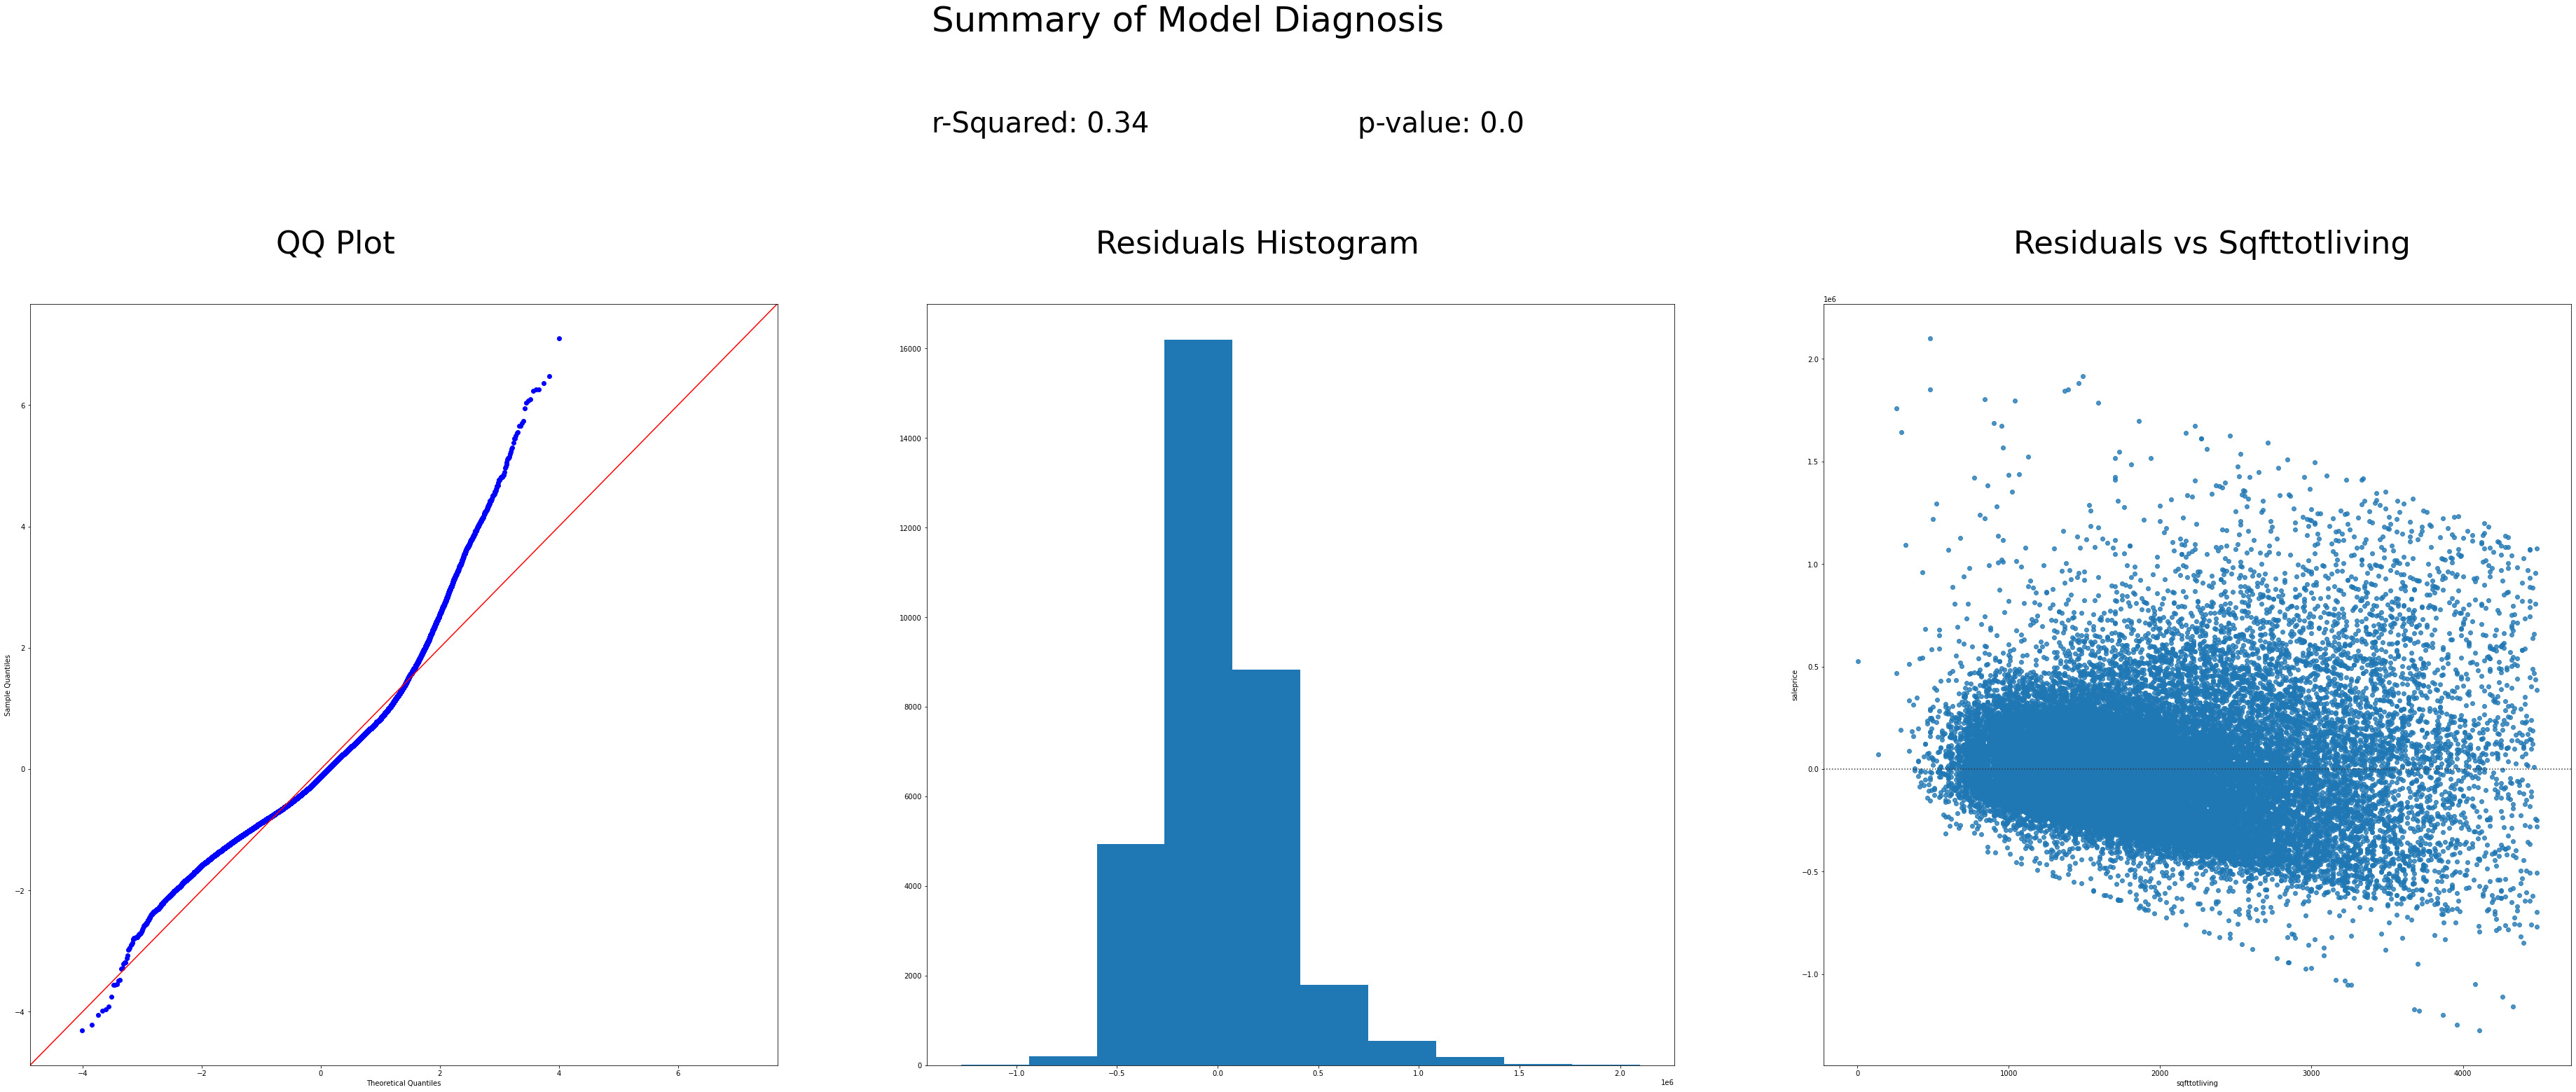

In [67]:
sqfttotliving = kc_data['sqfttotliving']
saleprice = kc_data['saleprice']
fig = 'saleprice ~ sqfttotliving'
sqfttotliving_model = smf.ols(formula=fig, data=kc_data).fit()
model_diagnosis(sqfttotliving_model, sqfttotliving, 'Sqfttotliving', saleprice)

#### Residuals:
Since the residuals are hugging the line in the middle but moving away at the tails, we can determine this violates the assumption of normality. The sharp incline at the top is likely a result of the right skewed data of our sales price.

#### Homoscedasticity:
For a first model, I am hopeful looking at these results. However, due to the cone shape and fanning outwards as x gets larger, I would say that this model violates the homoscedasticity assumption.
At the risk of losing more data, I may consider narrowing the price range a bit further.

## Model Iterations: Adding More Features

To start adding more features to the model model, I'll look at the features with correlations with sale price greater than 0.2:

In [68]:
sorted_corrs[sorted_corrs > 0.2]

saleprice           1.000000
bldggrade           0.602441
sqfttotliving       0.582776
township            0.469307
bathfullcount       0.285041
territorial         0.271712
bedrooms            0.269357
sqfttotbasement     0.259356
sqftfinbasement     0.250262
finbasementgrade    0.235648
sqftdeck            0.215990
lakewashington      0.208742
Name: saleprice, dtype: float64

I can make the following determinations based on this list:

-The square footage of decks and a view of Lake Washington are slightly correlated

-The square footage of a basement (finished or not) has some relevance

-The number of bathrooms has more relevance than the number of bedrooms

-The township is important (**location, location, location!**)

-The quality of the home (the grade) is most important.

I'll start by investigating highly correlated features that are directly connected to the house: total square footage, bathrooms and the porches. It should also be noted to avoid adding in extra sq footage, I won't add in basement features (real estate standard practice is that the total living square footage includes finished and unfinished basements)

### Bathroom count
I've examined that full bathroom count was highly correlated, however we have columns for the counts of half bath and three quater baths. Bathrooms are defined in real estate as as:

A half bath (or powder room) is considered a bathroom with only a toilet and sink with no tub or shower

A 3/4 bath is considered a bathroom with a toilet and shower with no tub

A full bath is considered a bathroom with a toilet, shower *and* tub.

I will calculate the total number of bathrooms per house for better understanding as follows:

In [69]:
kc_data['bathtotcount'] = kc_data['bathfullcount'] + (0.75 * kc_data['bath3qtrcount']) + (0.5 * kc_data['bathhalfcount'])

In [70]:
#I'll remove any homes that don't have a bathroom count:
kc_data = kc_data[kc_data['bathtotcount'] > 0]

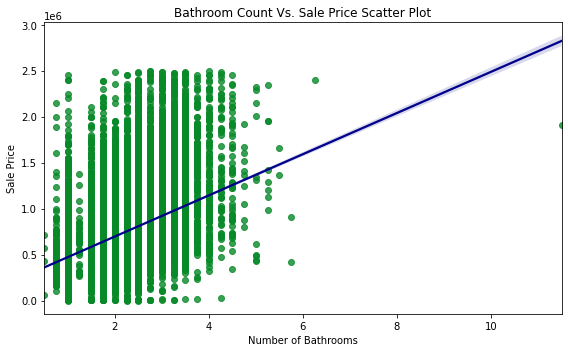

In [71]:
#Visualizing the linear relationship between total bathroom count and sale price:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(x = 'bathtotcount', y = 'saleprice', 
            data = kc_data, scatter_kws={"color": "#088A29"}, line_kws={"color": "darkblue"});
ax.set_title('Bathroom Count Vs. Sale Price Scatter Plot', fontsize = 12)
ax.tick_params(axis='both', labelsize=10)
plt.xlabel('Number of Bathrooms', fontsize = 10)
plt.ylabel('Sale Price', fontsize = 10)
plt.tight_layout()

C:\Users\15164\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


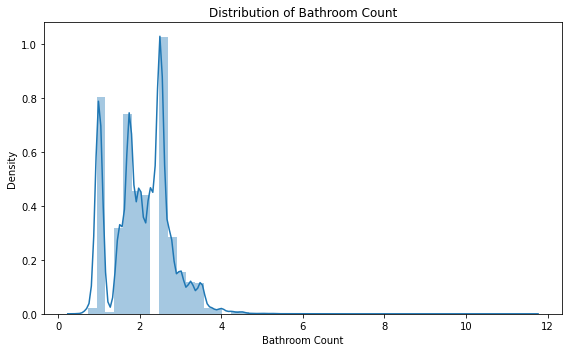

In [72]:
#Checking the distribution
fig, ax = plt.subplots(figsize=(8,5))
plt.title('Distribution of Bathroom Count', fontsize = 12)
sns.distplot(kc_data.bathtotcount, ax = ax)
ax.tick_params(axis = 'both', labelsize = 10)
plt.xlabel('Bathroom Count', fontsize = 10)
plt.tight_layout()

This data looks somewhat normal but right skewed, so I will see what a log transformation would do since removing all properties with no bathrooms.

C:\Users\15164\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


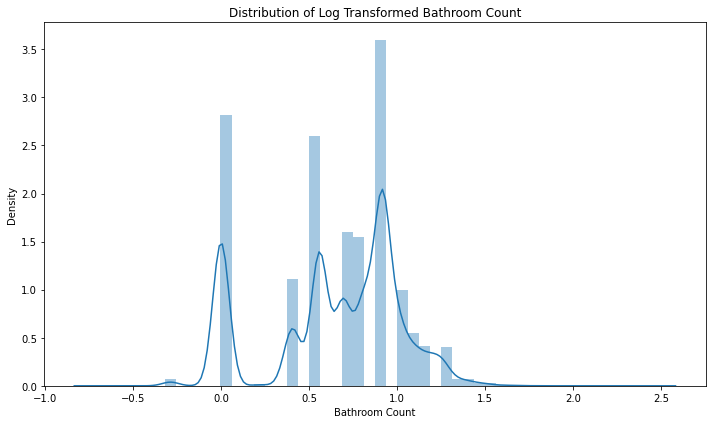

In [73]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Distribution of Log Transformed Bathroom Count', fontsize = 12)
sns.distplot(np.log(kc_data.bathtotcount), ax = ax)
ax.tick_params(axis = 'both', labelsize = 10)
plt.xlabel('Bathroom Count', fontsize = 10)
plt.tight_layout()

This seems to have skewed the data a bit more to the left. The data is multimodal (a distribution where there are many values or bins that contain more data than other nearby bins, usually separated by gaps) the distribution most likely won't improve much with a sqrt transformation.

###  Porch square footage
There two columns relating to porch square footage, and for the purpose of this analysis we will focus only on the enclosed porch column. I'll examine the relationship it has with sale price below:

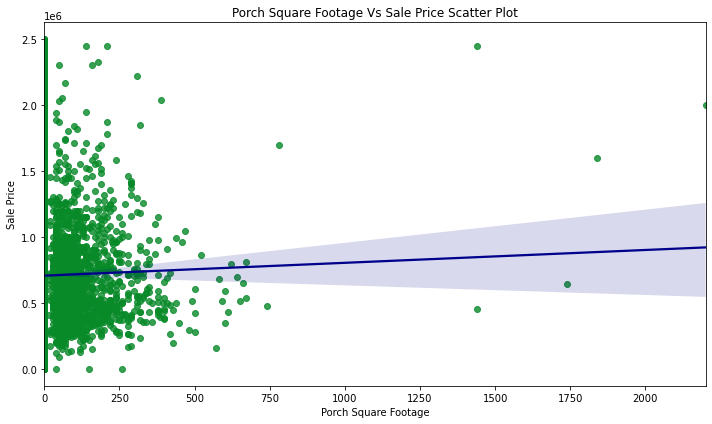

In [74]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x = 'sqftenclosedporch', y = 'saleprice', data = kc_data, scatter_kws={"color": "#088A29"},
            line_kws={"color": "darkblue"});
ax.set_title('Porch Square Footage Vs Sale Price Scatter Plot', fontsize = 12)
ax.tick_params(axis='both', labelsize=10)
plt.xlabel('Porch Square Footage', fontsize = 10)
plt.ylabel('Sale Price', fontsize = 10)
plt.tight_layout()

There seems to be a  very mild linear relationship here between enclosed porch sizes and sale prices,  however since there are a lot of '0' values included, the relationship is likely being affected.

I'll visualize the distribution of the enclosed porch data:

C:\Users\15164\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


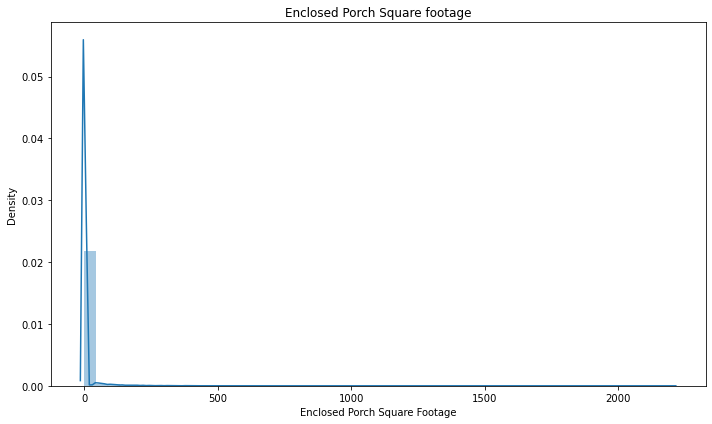

In [78]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Enclosed Porch Square footage', fontsize = 12)
sns.distplot(kc_data.sqftenclosedporch, ax = ax)
ax.tick_params(axis = 'both', labelsize = 10)
plt.xlabel('Enclosed Porch Square Footage', fontsize = 10)
plt.tight_layout()

The data is incredibly right skewed and due to a large number of '0' values in the data, a log transformation will not be feasible. Instead, I will try a sqrt transformation to see if it normalizes our data at all:

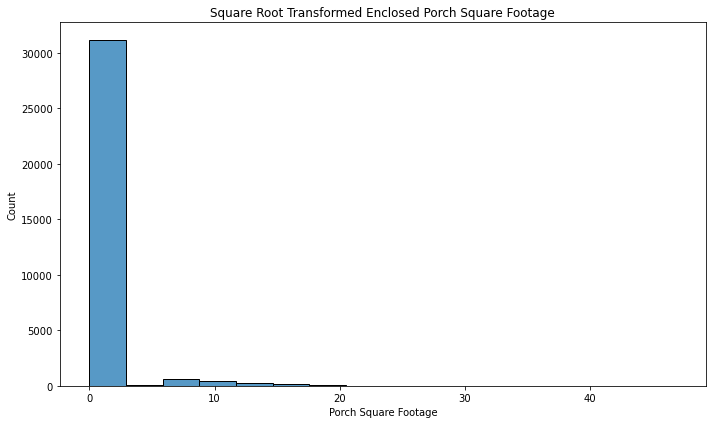

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Square Root Transformed Enclosed Porch Square Footage', fontsize = 12)
sns.histplot(np.sqrt(kc_data.sqftenclosedporch), ax = ax)
ax.tick_params(axis = 'both', labelsize = 10)
plt.xlabel('Porch Square Footage', fontsize = 10)
plt.tight_layout()

The data has not changed, so I will model using the sqrt data:

In [85]:
kc_data['sqrt_enclosedporch'] = np.sqrt(kc_data.sqftenclosedporch)

<ipython-input-85-79887bf97711>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_data['sqrt_enclosedporch'] = np.sqrt(kc_data.sqftenclosedporch)


## Second Model: saleprice ~ sqfttotliving + bathtotcount + sqrt_enclosedporch
Since I've investigated each feature in more detail and have determined they all have a linear relationship with saleprice, I will see if they improve the model by visualizing any multicollinearity that may exist between the features:

In [112]:
def heatmap_multi(x_features, df):
    """
    Creates a heatmap to show multicollinearity of all the x features in a model
    x_features (list):  A list of strings of the column names of the x features
    df:  the dataframe where the features are located
    Returns the plotted heatmap
    """
    df_x_feats = df.loc[:, x_features]

    x_corrs = df_x_feats.corr()

    fig, ax = plt.subplots(figsize = (10, 6))
    sns.heatmap(x_corrs, mask = None, vmax = 0.3, 
            center = 0, square = True, linewidths = 0.5, 
            cbar_kws = {'shrink': 0.8}, cmap='Reds', annot=True)
    ax.tick_params(axis='both', which='major', labelsize=8, labelrotation = 45)
    ax.set_title('Heat Map of Feature Multicollinearity', fontsize = 12)
    
    return plt.show()


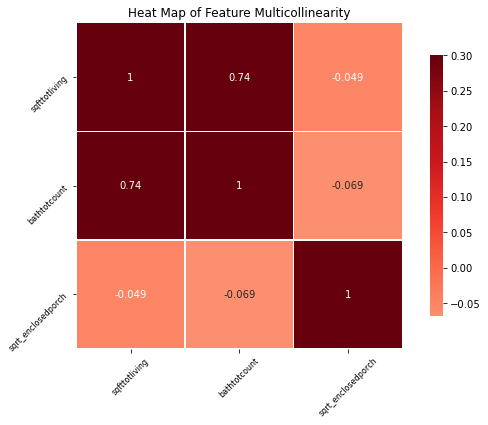

In [113]:
model_features = ['saleprice', 'sqfttotliving', 'bathtotcount', 'sqrt_enclosedporch']
#Creating x_features:
x_features = model_features.copy()
x_features.remove('saleprice')
heatmap_multi(x_features, kc_data)

Two features are highly correlate, however the maximium correlation value is 0.3 on the scale, so they have a 0.3 correlation only, which doesn't mean multicollinearity. Continuing with the model: